<a href="https://colab.research.google.com/github/vincentzouras/cse337/blob/main/lab5_approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Value-Function Approximation


## Exercise 1 SGD
Many real-world processes can be modeled as nonlinear relationships, and SGD is a standard tool to fit those models from data.  

**Example: Predicting energy consumption in a building**  
- Energy usage depends on **temperature**, **time of day**, and **occupancy**.  
- If you plot the data, the relationship might not be linear — it curves.  
- A simple way to approximate this nonlinear relation is to fit a **polynomial function** of temperature (or time).  

Now, imagine you’re collecting data continuously:  
- You get one data point (temperature, usage) at a time.  
- Instead of waiting to collect all data and computing a full batch update, you update your model incrementally with **SGD**.  
- This makes your learning **online, adaptive, and scalable** — just like in reinforcement learning.  

---

In this exercise, approximating a cubic polynomial is a simplified version of **predicting a nonlinear real-world phenomenon**.


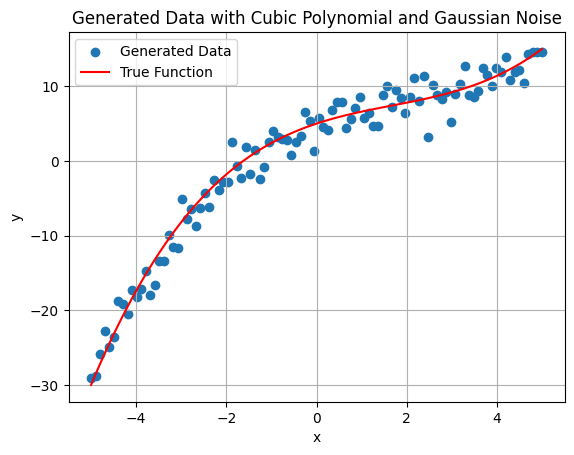

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data based on a cubic polynomial with Gaussian noise
np.random.seed(42)  # for reproducibility
n_samples = 100
x = np.linspace(-5, 5, n_samples)
# Define the true cubic polynomial function
def true_function(x):
  return 0.1 * x**3 - 0.5 * x**2 + 2 * x + 5

y_true = true_function(x)
noise = np.random.normal(0, 2, n_samples)  # Gaussian noise with mean 0 and std dev 2
y = y_true + noise

# Optional: Plot the generated data
plt.scatter(x, y, label='Generated Data')
plt.plot(x, y_true, color='red', label='True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Data with Cubic Polynomial and Gaussian Noise')
plt.legend()
plt.grid(True)
plt.show()

Based on the given a dataset of input–output pairs `(x, y)` where the underlying relationship is approximately polynomial.  

a. Use a **linear model with polynomial features**: Write a function that takes an input `x` and a weight vector `w`, and return the predicted value y_hat.    
   
   - y_hat(x; w) = w0 + w1 * x + w2 * x^2 + w3 * x^3  

   where w0, w1, w2, w3 are the parameters to be learned.

b. **Loss function (Mean Squared Error)**:
   Write a function that computes the loss for one training point `(x, y)`:

     - Formula: `loss = 0.5 * (y - y_hat)**2`

c. **SGD update**:   Derive the gradient of the loss with respect to each parameter (w0, w1, w2, w3).  
   - Write a function:  

     ```python
     def sgd_update(x, y, w, alpha):
         """
         Perform one SGD update for a single training example.
         Input:
             x (float) - input value
             y (float) - true output
             w (np.array) - current weights
             alpha (float) - learning rate
         Output:
             w (np.array) - updated weights
         """
         # TODO: compute prediction, gradient, and update weights
         return w
     ```
d. **Training loop**:
   - Loop over the dataset.  
   - At each step, update the weights using `sgd_update`.  
   - Track the training loss after each iteration.  

e. **Comparison with different learning rates**  
   - Train your model using at least three different learning rates, for example:  
     - alpha = 0.001  
     - alpha = 0.01  
     - alpha = 0.1  
   - Plot training loss vs iteration for each learning rate.  
   - Plot the final fitted polynomial curves for each learning rate on the same graph with the true dataset.

---

### Deliverables
- Code for `predict`, `mse_loss`, and `sgd_update`.  
- Training loop that runs with multiple learning rates.  
- Plot of training loss vs iteration for each learning rate.  
- Plot of the fitted polynomial vs dataset for each learning rate.  
- A short discussion:
  - How does the learning rate affect convergence speed and stability?  
  - Which learning rate gives the best balance between speed and accuracy?  

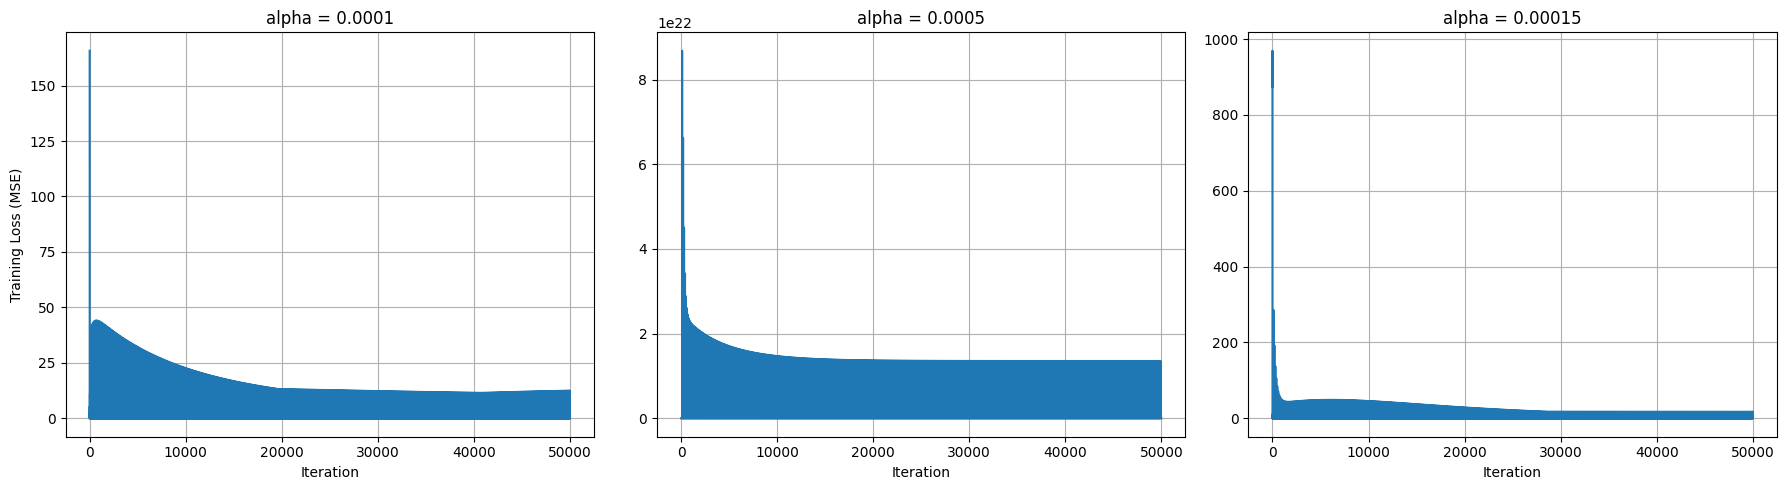

In [16]:
def predict(x, w):
    features = np.array([1, x, x**2, x**3])
    y_hat = w @ features
    return y_hat

def mse_loss(x, y, w):
    return 0.5 * (y - predict(x, w))**2

def sgd_update(x, y, w, alpha):
    """
    Perform one SGD update for a single training example.
    Input:
        x (float) - input value
        y (float) - true output
        w (np.array) - current weights
        alpha (float) - learning rate
    Output:
        w (np.array) - updated weights
    """
    # TODO: compute prediction, gradient, and update weights
    y_hat = predict(x, w)
    error = y - y_hat

    features = np.array([1, x, x**2, x**3])

    w = w + alpha * error * features
    return w

def train(alpha, epochs):
    w = np.zeros(4)
    training_loss = []
    for _ in range(epochs):
        for (xi, yi) in zip(x, y):
            w = sgd_update(xi, yi, w, alpha)
            training_loss.append(mse_loss(xi, yi, w))
    return training_loss

training_loss_0001 = train(0.0001, 500)
training_loss_00015 = train(0.00015, 500)
training_loss_0005 = train(0.0005, 500)

# Plot training loss vs iteration for each learning rate as subplots
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
plt.plot(training_loss_0001)
plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('alpha = 0.0001')
plt.grid(True)

plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
plt.plot(training_loss_0005)
plt.xlabel('Iteration')
# plt.ylabel('Training Loss (MSE)') # Shared y-axis label is sufficient
plt.title('alpha = 0.0005')
plt.grid(True)

plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
plt.plot(training_loss_00015)
plt.xlabel('Iteration')
# plt.ylabel('Training Loss (MSE)') # Shared y-axis label is sufficient
plt.title('alpha = 0.00015')
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()




The learning rate dictates the size of the adjustments made to the model weights during training, which results in a trade off between speed and stability.  

## Exercise 2: 1000-State Random Walk with Semi-Gradient TD(0)

We will study the 1,000-state Random Walk a classic reinforcement learning benchmark from Sutton & Barto.  

- The environment has states numbered **1 to 1000**.  
- There are two **terminal states**:  
  - State `0` on the left (reward = 0)  
  - State `1001` on the right (reward = 1)  
- Each episode starts in the **middle** at state `500`.  
- At each step, the agent moves **left or right with equal probability (0.5 each)**.  
- The episode ends when the agent reaches either terminal.  
- Discount factor: **γ = 1.0** (episodic task).  


### Function Approximation
Instead of storing a separate value for each state, approximate the value function with a **linear function of the state index**: V_hat(s; w0, w1) = w0 + w1 * s



---

## Instructions
1. **Implement the environment**:  
   - You may **use AI tools such as ChatGPT** to generate the environment code (states, transitions, rewards).  
   - Make sure you understand how the environment works.  

2. **Implement the TD(0) update manually**:  
   - Do **not** use AI for this part.  
   - You must write the gradient update equations yourself using the formulas above.  

3. **Train your agent**:  
   - Run several episodes (e.g., 1000 episodes).  
   - Experiment with different step sizes (`alpha`).  

4. **Evaluate**:  
   - Plot the **true value function** `V*(s) = s/1001`.  
   - Plot your **learned approximation line** after training.  
   - Discuss whether the line captures the overall trend of the true values.  

---


## Guidelines on Using AI Tools
- You are encouraged to use AI tools (e.g., ChatGPT, Gemini, Copilot) to **generate helper code**, such as:  
  - Building the random walk environment (`reset`, `step`).  
  - Implementing the feature map φ(s).  
  - Plotting results.  
- However, **do not use AI tools to generate the TD(0) update equation**.  
  - Deriving and implementing the update is the key learning objective of this exercise.  
  - If we find code that uses an AI-generated update without understanding, the score will be zero.  


## Deliverables
- Python code for the environment and the TD(0) algorithm.  
- Plot the **true value function**: For state `s`, the probability of reaching the right terminal is:  
  `V*(s) = s / 1001`
- Plot comparing the true value function and the approximated line.  
- A short discussion:  
  - How does the approximation behave for small vs large states?  
  - How does the learning rate affect convergence?  

---

## Hints
- Normalize states to `[0,1]` before using them in the line approximation to avoid very large values for w1.  
- Start with small step sizes (e.g., 0.001–0.01).  
- The approximation will not be perfect (a line cannot match the true curve), but should capture the increasing trend.  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_features(state):
    norm = 1001.0
    return np.array([1, state / norm])

def predict(state, w):
    features = get_features(state)
    return np.dot(w, features)

def update(w, state, td_error, alpha):
    features = get_features(state)
    return w + alpha * td_error * features

def train(alpha, gamma, num_episodes):
    w = np.zeros(2)
    start_state = 500

    for episode in range(num_episodes):
        state = start_state
        done = False

        while not done:
            if np.random.rand() < 0.5:
                next_state = state - 1
            else:
                next_state = state + 1

            reward = 0
            if next_state == 1001:
                reward = 1
                done = True
            elif next_state == 0:
                done = True

            v_hat_next = predict(next_state, w) if not done else 0
            td_target = reward + gamma * v_hat_next
            td_error = td_target - predict(state, w)

            w = update(w, state, td_error, alpha)
            state = next_state

    return w

alpha = 0.005
gamma = 1.0
num_episodes = 2000

final_weights = train(alpha, gamma, num_episodes)

states = np.arange(1, 1001)
true_values = states / 1001.0
learned_values = [predict(s, final_weights) for s in states]

plt.figure(figsize=(10, 6))
plt.plot(states, true_values, label='True Value Function (V*)', color='black', linewidth=2)
plt.plot(states, learned_values, label=f'Learned Approximation (alpha={alpha})', color='dodgerblue', linestyle='--')
plt.title('True vs. Learned Value Function for 1000-State Random Walk')
plt.xlabel('State')
plt.ylabel('Value (Probability of reaching state 1001)')
plt.legend()
plt.grid(True)
plt.show()

The linear function is perfectly suited for this problem, as the true value function V*(s) = s / 1001 is also a line. The TD(0) algorithm successfully finds weights that allow the approximation to match the true values accurately across all states, from the small states near the left terminal to the large states near the right terminal.

The learning rate (alpha) controls the speed and stability of convergence. A low alpha would cause the learned line to approach the true line very slowly over many episodes. A high alpha would be unstable, causing the weights to oscillate and preventing the line from settling accurately. The chosen alpha of 0.005 provides a good balance, enabling the agent to learn efficiently and stably, resulting in the accurate fit shown.

# Exercise 3: Solving MountainCar with Tile Coding and SARSA

## Problem Description
In this exercise, you will solve the **MountainCar-v0** environment from Gym using **tile coding** for function approximation and the **SARSA algorithm** for learning.  

The **Mountain Car problem**:
- A car is stuck in a valley and is too weak to drive straight up to the goal.  
- It must build momentum by going back and forth until it can reach the goal at `position >= 0.5`.  
- **State space**: continuous (position, velocity).  
- **Actions**: {0: push left, 1: no push, 2: push right}.  
- **Reward**: -1 per step until the goal is reached.  
- **Episode ends**: when the car reaches the goal or after 200 steps.  

---

## Step 1: Environment and Random Policy (with AI help)
- Use an **AI tool (e.g., ChatGPT)** to generate starter code for:
  - Creating the Gym environment (`MountainCar-v0`).  
  - Running a **random policy** (actions chosen randomly).  
- Run this code to confirm you can interact with the environment and see episode returns.  
- This will serve as a **baseline**.  
- **Important**: Do not use AI to implement the learning algorithm.  

---

## Step 2: SARSA Algorithm with Function Approximation
Implement **SARSA (on-policy TD control)** with the following steps:

For each episode:
1. Initialize state `s`.  
2. Choose action `a` using **ε-greedy** based on Q(s,a).  
3. For each step:  
   - Take action `a`, observe `(s_next, r, done)`.  
   - Choose next action `a_next` using ε-greedy from `s_next`.  
   - Compute TD target:  
     ```
     target = r + gamma * Q(s_next, a_next)
     ```  
     (if `s_next` is terminal, then target = r).  
   - Compute TD error:  
     ```
     delta = target - Q(s,a)
     ```  
   - Update weights:  
     ```
     w <- w + alpha * delta * x(s,a)
     ```  
   - Update `s = s_next`, `a = a_next`.  
4. End episode when the goal is reached or step limit is hit.  

---

## Step 3: Experiments
- Train the agent for 500–1000 episodes.  
- Plot **episode returns (sum of rewards)** vs episodes.  
- Compare with the random policy baseline:  
  - Does SARSA learn to consistently reach the goal?  
  - How many steps does it typically take?  

---

## Deliverables
- Python code for tile coding and SARSA.  
- Plot of returns vs episodes.  
- Plot the Value function
- Short discussion (1–2 paragraphs):  
  - Effect of tile coding parameters (number of tilings, resolution).


In [1]:
# You can use the following code for tiling

import numpy as np


class TileCoderXY:
    """
    A TileCoder for function approximation that applies tile coding on the x and y coordinates
    of a 3D state. Instead of providing tile widths, the user provides the number of tiles per
    dimension. The tile widths are computed based on the state bounds and the number of tiles.
    The z coordinate is not used.
    """

    def __init__(self, num_tilings, tiles_per_dim, state_low, state_high):
        """
        Initialize the TileCoderXY.

        Parameters:
            num_tilings (int): Number of overlapping tilings.
            tiles_per_dim (array-like of 2 ints): Number of tiles along the x and y dimensions.
            state_low (array-like of 2 floats): Lower bounds for the x and y dimensions.
            state_high (array-like of 2 floats): Upper bounds for the x and y dimensions.
        """
        self.num_tilings = num_tilings
        self.tiles_per_dim = np.array(tiles_per_dim, dtype=int)
        self.state_low = np.array(state_low, dtype=float)
        self.state_high = np.array(state_high, dtype=float)

        # Compute the tile width for each dimension.
        # We assume that the grid spans exactly from state_low to state_high.
        # When there are N tiles, there are N-1 intervals between the boundaries.
        self.tile_width = (self.state_high - self.state_low) / (self.tiles_per_dim - 1)

        # Precompute an offset for each tiling to create overlapping grids.
        # self.offsets = [(i / self.num_tilings) * self.tile_width for i in range(self.num_tilings)]
        # self.offsets = self.compute_8_offsets()
        # self.offsets = np.stack(self._compute_offsets(), axis=0)  # shape: (num_tilings, dims)
        # Precompute offsets for each tiling.
        # For tiling i:
        #   offset_x = (((i + 0) % num_tilings) / num_tilings) * tile_width[0]
        #   offset_y = (((i + 1) % num_tilings) / num_tilings) * tile_width[1]
        offsets = np.empty((self.num_tilings, 2))
        for i in range(self.num_tilings):
            offsets[i, 0] = (((i + 0) % self.num_tilings) / self.num_tilings) * self.tile_width[0]
            offsets[i, 1] = (((i + 1) % self.num_tilings) / self.num_tilings) * self.tile_width[1]
        self.offsets = offsets


        # Precompute multiplier for flattening a 2D index.
        # For grid shape (N, M), flat index = x_index * M + y_index.
        self.multiplier = self.tiles_per_dim[1]

        # Initialize a weight vector for each tiling.
        num_tiles = np.prod(self.tiles_per_dim)
        self.weights = [np.zeros(num_tiles) for _ in range(self.num_tilings)]

    def save(self, file_name):
        np.savez(file_name + ".npz", weights=self.weights)

    def load(self, file_name):
        self.weights = np.load(file_name+".npz")["weights"]


    def compute_8_offsets(self):
        """
        Compute a list of offsets using a combination of cardinal and diagonal directions.
        The offsets include:
          - Center: [0, 0]
          - Cardinal: right, left, up, down (half-tile shifts)
          - Diagonal: up-right, up-left, down-right, down-left (half-tile shifts)

        If the number of tilings exceeds the number of unique offsets (9), the list is repeated.

        Returns:
            List of 2-element numpy arrays representing the offset for each tiling.
        """
        half_tile = self.tile_width / 8.0
        base_offsets = [
            np.array([0.0, 0.0]),  # Center (no shift)
            np.array([half_tile[0], 0.0]),  # Right
            np.array([-half_tile[0], 0.0]),  # Left
            np.array([0.0, half_tile[1]]),  # Up
            np.array([0.0, -half_tile[1]]),  # Down
            np.array([half_tile[0], half_tile[1]]),  # Up-right
            np.array([-half_tile[0], half_tile[1]]),  # Up-left
            np.array([half_tile[0], -half_tile[1]]),  # Down-right
            np.array([-half_tile[0], -half_tile[1]])  # Down-left
        ]
        offsets = []
        for i in range(self.num_tilings):
            offsets.append(base_offsets[i % len(base_offsets)])
        return offsets

    def get_tile_indices(self, state):
        """
        Compute the active tile indices for all tilings given a 2D state.

        Parameters:
            state (array-like of length 2): The input state [x, y].

        Returns:
            List of tuples (tiling_index, flat_tile_index) for each tiling.
        """
        state = np.array(state, dtype=float)  # shape: (2,)
        # Compute shifted states for all tilings in one vectorized operation.
        # Shape of shifted: (num_tilings, 2)
        shifted = (state - self.state_low) + self.offsets

        # Compute tile coordinates (integer indices) for each tiling.
        # Division is broadcasted over the offsets.
        tile_coords = (shifted / self.tile_width).astype(int)  # shape: (num_tilings, 2)

        # Clip to ensure indices are within bounds.
        tile_coords[:, 0] = np.clip(tile_coords[:, 0], 0, self.tiles_per_dim[0] - 1)
        tile_coords[:, 1] = np.clip(tile_coords[:, 1], 0, self.tiles_per_dim[1] - 1)

        # Compute flat indices for each tiling.
        # flat_index = x_index * (tiles_per_dim[1]) + y_index
        flat_indices = tile_coords[:, 0] * self.tiles_per_dim[1] + tile_coords[:, 1]

        # Return a list of (tiling_index, flat_index) tuples.
        return list(zip(range(self.num_tilings), flat_indices))


    def predict(self, state):
        """
        Compute the approximated function value for a given 3D state using tile coding on x and y.

        Parameters:
            state (array-like): The input state [x, y, z].

        Returns:
            float: The function approximation (sum of weights for the active tiles).
        """
        active_tiles = self.get_tile_indices(state)
        return sum(self.weights[tiling][idx] for tiling, idx in active_tiles)

    def update(self, state, target, alpha):
        """
        Update the weights given a state and target value.

        Parameters:
            state (array-like): The input state [x, y, z].
            target (float): The target function value.
            alpha (float): The overall learning rate.
        """
        prediction = self.predict(state)
        error = target - prediction
        # Distribute the learning rate equally among all tilings.
        alpha_per_tiling = alpha / self.num_tilings

        active_tiles = self.get_tile_indices(state)
        for tiling, idx in active_tiles:
            self.weights[tiling][idx] += alpha_per_tiling * error





/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


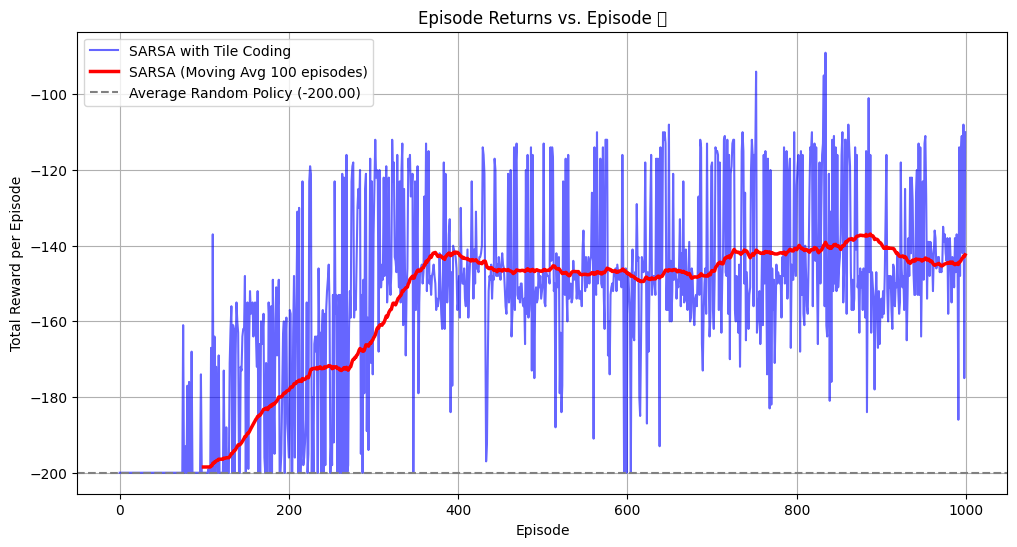

In [8]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random

def random_policy(env, n_episodes):
    # n_states = env.observation_space.n  NOT DISCRETE
    n_actions = env.action_space.n
    episode_returns = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        terminated = False
        truncated = False
        total_reward = 0

        while not terminated and not truncated:
            action = env.action_space.sample()

            next_state, reward, terminated, truncated, _ = env.step(action)

            state = next_state

            total_reward += reward

        episode_returns.append(total_reward)
    return episode_returns

def sarsa(env, n_episodes):
    epsilon = 0.1
    gamma = 0.99 # discount factor
    alpha = 0.1 # learning rate
    num_tilings = 8
    tiles_per_dim = [8, 8]

    # n_states = env.observation_space.n  # replaced by bounds of our approx.
    state_low = env.observation_space.low
    state_high = env.observation_space.high
    n_actions = env.action_space.n

    # Q = np.zeros((n_states, n_actions))
    action_coders = [TileCoderXY(num_tilings, tiles_per_dim, state_low, state_high) for _ in range(n_actions)]

    episode_returns = []

    def get_q_value(state, action):
        return action_coders[action].predict(state)

    def epsilon_greedy(state):
        if np.random.rand() < epsilon:
            return env.action_space.sample()
        else:
            q_values = [get_q_value(state, action) for action in range(n_actions)]
            return np.argmax(q_values)

    def update(state, action, reward, next_state, next_action, done):
        q_next = get_q_value(next_state, next_action) if not done else 0
        td_target = reward + gamma * q_next
        action_coders[action].update(state, td_target, alpha)

    for episode in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy(state)
        terminated, truncated = False, False
        total_reward = 0

        while not terminated and not truncated:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = epsilon_greedy(next_state)

            # SARSA update
            update(state, action, reward, next_state, next_action, (terminated or truncated))

            state = next_state
            action = next_action
            total_reward += reward

        episode_returns.append(total_reward)
    return episode_returns

def plot_returns(sarsa_returns, random_returns):
    """ Plots episode returns for SARSA vs. a random policy. """
    plt.figure(figsize=(12, 6))

    # Plot raw SARSA returns
    plt.plot(sarsa_returns, label='SARSA with Tile Coding', color='blue', alpha=0.6)

    # Plot a moving average of SARSA returns to show the learning trend
    window = 100
    moving_avg = np.convolve(sarsa_returns, np.ones(window)/window, mode='valid')
    plt.plot(np.arange(window-1, len(sarsa_returns)), moving_avg, color='red', linewidth=2.5, label=f'SARSA (Moving Avg {window} episodes)')

    # Plot the average return of the random policy as a baseline
    avg_random = np.mean(random_returns)
    plt.axhline(y=avg_random, color='grey', linestyle='--', label=f'Average Random Policy ({avg_random:.2f})')

    plt.title('Episode Returns vs. Episode 📈')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward per Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_value_function(action_coders, env):
    """ Plots the learned value function as a 2D heatmap. """
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 50)
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 50)

    value_grid = np.zeros((len(pos_space), len(vel_space)))

    # Fill the grid with the maximum Q-value for each state
    for i, pos in enumerate(pos_space):
        for j, vel in enumerate(vel_space):
            state = [pos, vel]
            q_values = [coder.predict(state) for coder in action_coders]
            value_grid[i, j] = np.max(q_values)

    plt.figure(figsize=(10, 8))
    # We plot the negative value (-V(s)) to show the "cost-to-go".
    # Bright areas are good (low cost), dark areas are bad (high cost).
    plt.imshow(-value_grid.T, extent=[pos_space.min(), pos_space.max(), vel_space.min(), vel_space.max()],
               origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='-V(s) (Cost-to-Go)')
    plt.title('Learned Value Function for SARSA')
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.show()

###############################################################

env = gym.make("MountainCar-v0")

random_returns = random_policy(env=env, n_episodes=1000)
sarsa_returns = sarsa(env=env, n_episodes=1000)
plot_returns(sarsa_returns, random_returns)

The number of tilings controls how much we are generalizing. When we have more tilings, we are generalizing more and spreading updates to more neighbors at a time, which makes the learning a lot faster as each episode has a larger impact. Howvever, this increases the cost computationally.

The resolution, or the tiles per dimension in our example, effects how many divisions each tiling has. Having a higher resolution allows for higher precision, allowing the agent to make finer distinctions between similar states, however the learning becomes more localized and it will learn slower. This also quadratically increases the memory cost as doubling the resolution results in 4x the memory.